Chi-square: 5545.24
Chi-square per degree of freedom: 59.63


/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85073/1079414800.py:18: RuntimeWarning: invalid value encountered in power
  return amp * a * np.power(b + (x - mean) / sigma, -n)
/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85073/1079414800.py:11: RuntimeWarning: overflow encountered in power
  a = np.power(n / np.abs(alpha), n) * np.exp(-np.power(np.abs(alpha), 2) / 2)
/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85073/1079414800.py:18: RuntimeWarning: invalid value encountered in multiply
  return amp * a * np.power(b + (x - mean) / sigma, -n)
/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85073/1079414800.py:18: RuntimeWarning: overflow encountered in scalar multiply
  return amp * a * np.power(b + (x - mean) / sigma, -n)


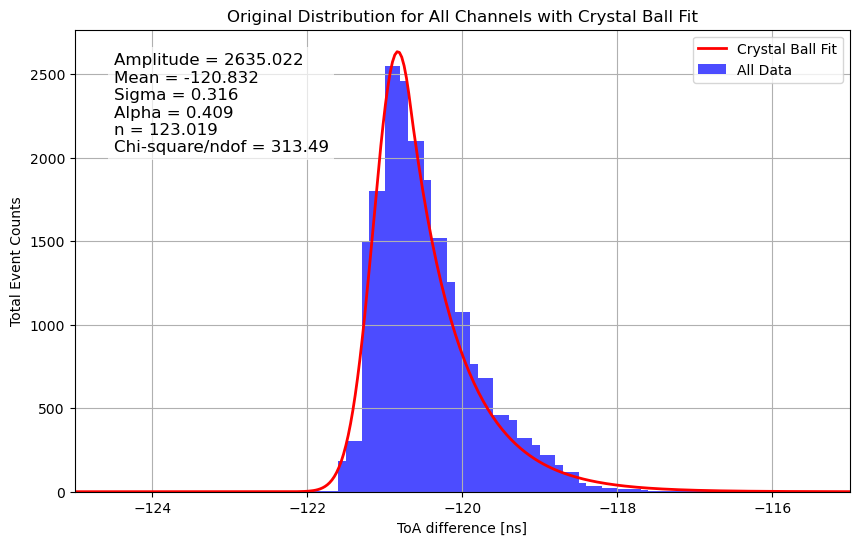

In [42]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#O
def crystalball(x, amp, mean, sigma, alpha, n):
    """ Crystal Ball function definition with right tail """
    sqrt_pi_over_2 = np.sqrt(np.pi / 2)
    sqrt_2 = np.sqrt(2)
    
    a = np.power(n / np.abs(alpha), n) * np.exp(-np.power(np.abs(alpha), 2) / 2)
    b = n / np.abs(alpha) - np.abs(alpha)
    
    def left_tail(x):
        return amp * np.exp(-np.power(x - mean, 2) / (2 * sigma ** 2))
    
    def right_tail(x):
        return amp * a * np.power(b + (x - mean) / sigma, -n)
    
    result = np.where((x - mean) / sigma > alpha, right_tail(x), left_tail(x))
    return result

def import_data(file_path, hist_name):
    root_file = uproot.open(file_path)
    hist = root_file[hist_name]
    w, x_edges, y_edges = hist.to_numpy()
    return w, x_edges, y_edges 

file_path = 'run_0419_afterTWC.root'
excluded_channels = [1, 7, 21]
channels = [ch for ch in range(64) if ch not in excluded_channels] 
channels = [36]

bin_width = 0.1
y_min = -130
y_max = -100
uniform_bin_edges = np.arange(y_min, y_max + bin_width, bin_width)
uniform_event_counts_per_bin = np.zeros(len(uniform_bin_edges) - 1)

for channel in channels:
    hist_name_template = 'original_hist_ch{0};1'
    hist_name = hist_name_template.format(channel)

    try:
        w, ToT_edges, ToA_edges = import_data(file_path, hist_name)

        y_indices = np.where((ToA_edges >= y_min) & (ToA_edges <= y_max))[0]
        if ToA_edges[y_indices[-1]] > y_max:
            y_indices = y_indices[:-1]

        w_sliced = w[:, y_indices[:-1]]
        ToA_edges_sliced = ToA_edges[y_indices]

        for i in range(len(ToA_edges_sliced) - 1):
            bin_min = ToA_edges_sliced[i]
            bin_max = ToA_edges_sliced[i + 1]
            bin_event_count = np.sum(w_sliced[:, i])  

            uniform_bin_mask = (uniform_bin_edges[:-1] < bin_max) & (uniform_bin_edges[1:] > bin_min)
            overlap_bins = np.where(uniform_bin_mask)[0]

            for bin_idx in overlap_bins:
                overlap_min = max(bin_min, uniform_bin_edges[bin_idx])
                overlap_max = min(bin_max, uniform_bin_edges[bin_idx + 1])
                overlap_fraction = (overlap_max - overlap_min) / (bin_max - bin_min)
                
                uniform_event_counts_per_bin[bin_idx] += bin_event_count * overlap_fraction

    except KeyError:
        print(f"Histogram for channel {channel} not found, skipping.")

uniform_bin_centers = (uniform_bin_edges[:-1] + uniform_bin_edges[1:]) / 2

fit_range_mask = (uniform_bin_centers >= -125) & (uniform_bin_centers <= -115)
fit_bin_centers = uniform_bin_centers[fit_range_mask]
fit_event_counts = uniform_event_counts_per_bin[fit_range_mask]

initial_guess = [fit_event_counts.max(), fit_bin_centers[np.argmax(fit_event_counts)], 1, 1.5, 2]

try:
    popt, pcov = curve_fit(crystalball, fit_bin_centers, fit_event_counts, p0=initial_guess)
    amplitude, mean, sigma, alpha, n = popt

    x_smooth = np.linspace(uniform_bin_edges[0], uniform_bin_edges[-1], 1000)
    y_smooth = crystalball(x_smooth, amplitude, mean, sigma, 0.49, n)

    expected_counts = crystalball(fit_bin_centers, *popt)
    errors = np.sqrt(fit_event_counts)

    non_zero_mask = (fit_event_counts > 0)
    chi_square = np.sum(((fit_event_counts[non_zero_mask] - expected_counts[non_zero_mask]) / errors[non_zero_mask]) ** 2)
    ndof = np.sum(non_zero_mask) - len(popt) 
    
    chi_square_per_dof = chi_square / ndof

    print(f"Chi-square: {chi_square:.2f}")
    print(f"Chi-square per degree of freedom: {chi_square_per_dof:.2f}")

except RuntimeError:
    amplitude, mean, sigma, alpha, n = np.nan, np.nan, np.nan, np.nan, np.nan
    chi_square, chi_square_per_dof = np.nan, np.nan
    print("Crystal Ball fit failed")

# Plot
plt.figure(figsize=(10, 6))
plt.bar(uniform_bin_centers, uniform_event_counts_per_bin, width=bin_width, align='center', color='blue', alpha=0.7, linewidth=0, edgecolor='none', label='All Data')
plt.plot(x_smooth, y_smooth, 'r-', label='Crystal Ball Fit', linewidth=2)

plt.text(0.05, 0.95, f'Amplitude = {amplitude:.3f}\nMean = {mean:.3f}\nSigma = {sigma:.3f}\n'
                     f'Alpha = {alpha:.3f}\nn = {n:.3f}\nChi-square/ndof = 313.49', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.xlim(-125, -115)
plt.xlabel('ToA difference [ns]')
plt.ylabel('Total Event Counts')
plt.title(f'Original Distribution for All Channels with Crystal Ball Fit')
plt.grid(True)
plt.legend()

plt.show()


Chi-square: 2268.77
Chi-square per degree of freedom: 16.93


/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85073/1969425012.py:18: RuntimeWarning: invalid value encountered in power
  return np.where(valid, amp * a * np.power(b + (x - mean) / sigma, -n), np.nan)


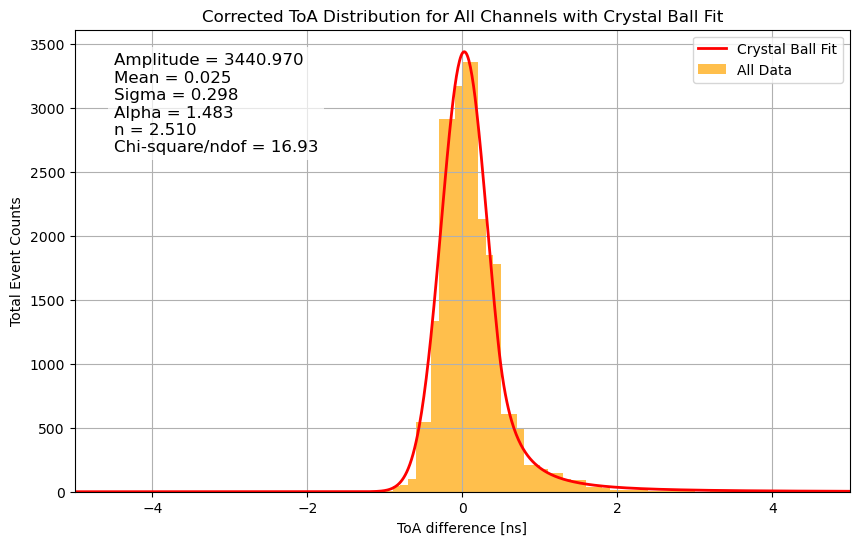

In [44]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def crystalball(x, amp, mean, sigma, alpha, n):
    sqrt_pi_over_2 = np.sqrt(np.pi / 2)
    sqrt_2 = np.sqrt(2)
    
    a = np.power(n / np.abs(alpha), n) * np.exp(-np.power(np.abs(alpha), 2) / 2)
    b = n / np.abs(alpha) - np.abs(alpha)
    
    def left_tail(x):
        return amp * np.exp(-np.power(x - mean, 2) / (2 * sigma ** 2))
    
    def right_tail(x):
        valid = (b + (x - mean) / sigma) > 0
        return np.where(valid, amp * a * np.power(b + (x - mean) / sigma, -n), np.nan)
    
    result = np.where((x - mean) / sigma > alpha, right_tail(x), left_tail(x))
    return result

def import_data(file_path, hist_name):
    root_file = uproot.open(file_path)
    hist = root_file[hist_name]
    w, x_edges, y_edges = hist.to_numpy()
    return w, x_edges, y_edges 

file_path = 'run_0419_afterTWC.root'
excluded_channels = [1, 7, 21]
channels = [ch for ch in range(64) if ch not in excluded_channels]
channels = [36]

uniform_bin_width = 0.1
uniform_bin_edges = np.arange(-10, 20 + uniform_bin_width, uniform_bin_width)
cumulative_event_counts = np.zeros(len(uniform_bin_edges) - 1)

plt.figure(figsize=(10, 6))

for channel in channels:
    try:
        hist_name_template = 'corrected_hist_ch{0};1'
        hist_name = hist_name_template.format(channel)
        w, ToT_edges, ToA_edges = import_data(file_path, hist_name)

        bin_edges = ToA_edges
        bin_widths = np.diff(bin_edges)
        event_counts_per_bin = np.sum(w, axis=0)

        for j in range(len(bin_edges) - 1):
            bin_min = bin_edges[j]
            bin_max = bin_edges[j + 1]
            bin_event_count = event_counts_per_bin[j]

            uniform_bin_mask = (uniform_bin_edges[:-1] < bin_max) & (uniform_bin_edges[1:] > bin_min)
            overlap_bins = np.where(uniform_bin_mask)[0]

            for bin_idx in overlap_bins:
                overlap_min = max(bin_min, uniform_bin_edges[bin_idx])
                overlap_max = min(bin_max, uniform_bin_edges[bin_idx + 1])
                overlap_fraction = (overlap_max - overlap_min) / (bin_max - bin_min)
                
                cumulative_event_counts[bin_idx] += bin_event_count * overlap_fraction
    
    except KeyError:
        print(f"Histogram for channel {channel} not found, skipping.")

uniform_bin_centers = (uniform_bin_edges[:-1] + uniform_bin_edges[1:]) / 2

fit_range_mask = (uniform_bin_centers >= -5) & (uniform_bin_centers <= 10)
fit_bin_centers = uniform_bin_centers[fit_range_mask]
fit_event_counts = cumulative_event_counts[fit_range_mask]

plt.bar(uniform_bin_centers, cumulative_event_counts, width=uniform_bin_width, color='orange', alpha=0.7, linewidth=0, edgecolor='none', label='All Data')

# Initial guess for Crystal Ball parameters: amplitude, mean, sigma, alpha, n
initial_guess = [fit_event_counts.max(), fit_bin_centers[np.argmax(fit_event_counts)], 1, 1.5, 2]

try:
    popt, pcov = curve_fit(crystalball, fit_bin_centers, fit_event_counts, p0=initial_guess, bounds=([0, -np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, 5, 60]))
    amplitude, mean, sigma, alpha, n = popt

    x_smooth = np.linspace(-5, 5, 1000)
    y_smooth = crystalball(x_smooth, amplitude, mean, sigma, alpha, n)

    plt.plot(x_smooth, y_smooth, 'r-', label='Crystal Ball Fit', linewidth=2)

    # Calculate chi-square
    expected_counts = crystalball(fit_bin_centers, *popt)
    errors = np.sqrt(fit_event_counts)

    non_zero_mask = (fit_event_counts > 0)
    chi_square = np.sum(((fit_event_counts[non_zero_mask] - expected_counts[non_zero_mask]) / errors[non_zero_mask]) ** 2)
    ndof = np.sum(non_zero_mask) - len(popt)  # degrees of freedom

    chi_square_per_dof = chi_square / ndof
    print(f"Chi-square: {chi_square:.2f}")
    print(f"Chi-square per degree of freedom: {chi_square_per_dof:.2f}")

except RuntimeError:
    print("Crystal Ball fit failed.")
    amplitude, mean, sigma, alpha, n = np.nan, np.nan, np.nan, np.nan, np.nan
    chi_square, chi_square_per_dof = np.nan, np.nan

plt.text(0.05, 0.95, f'Amplitude = {amplitude:.3f}\nMean = {mean:.3f}\nSigma = {sigma:.3f}\n'
                     f'Alpha = {alpha:.3f}\nn = {n:.3f}\n'
                     f'Chi-square/ndof = {chi_square_per_dof:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.xlim(-5, 5)
plt.xlabel('ToA difference [ns]')
plt.ylabel('Total Event Counts')
plt.title('Corrected ToA Distribution for All Channels with Crystal Ball Fit')

plt.legend()
plt.grid(True)
plt.show()


In [40]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

#save as PDF
def crystalball(x, amp, mean, sigma, alpha, n):
    sqrt_pi_over_2 = np.sqrt(np.pi / 2)
    sqrt_2 = np.sqrt(2)
    
    a = np.power(n / np.abs(alpha), n) * np.exp(-np.power(np.abs(alpha), 2) / 2)
    b = n / np.abs(alpha) - np.abs(alpha)
    
    def left_tail(x):
        return amp * np.exp(-np.power(x - mean, 2) / (2 * sigma ** 2))
    
    def right_tail(x):
        valid = (b + (x - mean) / sigma) > 0
        return np.where(valid, amp * a * np.power(b + (x - mean) / sigma, -n), np.nan)
    
    result = np.where((x - mean) / sigma > alpha, right_tail(x), left_tail(x))
    return result

def import_data(file_path, hist_name):
    root_file = uproot.open(file_path)
    hist = root_file[hist_name]
    w, x_edges, y_edges = hist.to_numpy()
    return w, x_edges, y_edges 

file_path = 'run_0419_afterTWC.root'
excluded_channels = [1, 7, 21]
channels = [ch for ch in range(64) if ch not in excluded_channels] 

uniform_bin_width = 0.1
uniform_bin_edges = np.arange(-10, 20 + uniform_bin_width, uniform_bin_width)

output_pdf_file = 'Corrected_ToA_Distribution_All_Channels_Crystal_Ball.pdf'

with PdfPages(output_pdf_file) as pdf:
    for channel in channels:
        try:
            cumulative_event_counts = np.zeros(len(uniform_bin_edges) - 1)
            hist_name_template = 'corrected_hist_ch{0};1'
            hist_name = hist_name_template.format(channel)
            w, ToT_edges, ToA_edges = import_data(file_path, hist_name)

            bin_edges = ToA_edges
            bin_widths = np.diff(bin_edges)
            event_counts_per_bin = np.sum(w, axis=0)

            for j in range(len(bin_edges) - 1):
                bin_min = bin_edges[j]
                bin_max = bin_edges[j + 1]
                bin_event_count = event_counts_per_bin[j]

                uniform_bin_mask = (uniform_bin_edges[:-1] < bin_max) & (uniform_bin_edges[1:] > bin_min)
                overlap_bins = np.where(uniform_bin_mask)[0]

                for bin_idx in overlap_bins:
                    overlap_min = max(bin_min, uniform_bin_edges[bin_idx])
                    overlap_max = min(bin_max, uniform_bin_edges[bin_idx + 1])
                    overlap_fraction = (overlap_max - overlap_min) / (bin_max - bin_min)

                    cumulative_event_counts[bin_idx] += bin_event_count * overlap_fraction

            uniform_bin_centers = (uniform_bin_edges[:-1] + uniform_bin_edges[1:]) / 2

            # Fitting range
            fit_range_mask = (uniform_bin_centers >= -5) & (uniform_bin_centers <= 10)
            fit_bin_centers = uniform_bin_centers[fit_range_mask]
            fit_event_counts = cumulative_event_counts[fit_range_mask]

            plt.figure(figsize=(10, 6))
            plt.bar(uniform_bin_centers, cumulative_event_counts, width=uniform_bin_width, color='orange', alpha=0.7, linewidth=0, edgecolor='none', label='All Data')

            # Initial guess for Crystal Ball parameters: amplitude, mean, sigma, alpha, n
            initial_guess = [fit_event_counts.max(), fit_bin_centers[np.argmax(fit_event_counts)], 1, 1.5, 2]

            try:
                popt, pcov = curve_fit(crystalball, fit_bin_centers, fit_event_counts, p0=initial_guess, bounds=([0, -np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, 5, 60]))
                amplitude, mean, sigma, alpha, n = popt
                x_smooth = np.linspace(-5, 5, 1000)
                y_smooth = crystalball(x_smooth, amplitude, mean, sigma, alpha, n)

                plt.plot(x_smooth, y_smooth, 'r-', label='Crystal Ball Fit', linewidth=2)

                expected_counts = crystalball(fit_bin_centers, *popt)
                errors = np.sqrt(fit_event_counts)

                non_zero_mask = (fit_event_counts > 0)
                chi_square = np.sum(((fit_event_counts[non_zero_mask] - expected_counts[non_zero_mask]) / errors[non_zero_mask]) ** 2)
                ndof = np.sum(non_zero_mask) - len(popt)  # degrees of freedom

                chi_square_per_dof = chi_square / ndof

                plt.text(0.05, 0.95, f'Amplitude = {amplitude:.3f}\nMean = {mean:.3f}\nSigma = {sigma:.3f}\n'
                                     f'Alpha = {alpha:.3f}\n'
                                     f'Chi-square/ndof = {chi_square_per_dof:.2f}', 
                         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left',
                         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

            except RuntimeError:
                print(f"Crystal Ball fit failed for channel {channel}.")
                amplitude, mean, sigma, alpha, n = np.nan, np.nan, np.nan, np.nan, np.nan
                chi_square, chi_square_per_dof = np.nan, np.nan

            plt.xlim(-5, 5)
            plt.xlabel('ToA difference [ns]')
            plt.ylabel('Total Event Counts')
            plt.title(f'Corrected ToA Distribution for Channel {channel} with Crystal Ball Fit')

            plt.legend()
            plt.grid(True)

            pdf.savefig()
            plt.close()

        except KeyError:
            print(f"Histogram for channel {channel} not found, skipping.")


/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85073/1215750855.py:20: RuntimeWarning: invalid value encountered in power
  return np.where(valid, amp * a * np.power(b + (x - mean) / sigma, -n), np.nan)
